In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/navigatorx-stgcn-legit/pytorch/default/1/layers.py
/kaggle/input/navigatorx-stgcn-legit/pytorch/default/1/data_utils.py
/kaggle/input/navigatorx-stgcn-legit/pytorch/default/1/models.py
/kaggle/input/navigatorx-stgcn-legit/pytorch/default/1/graph.py
/kaggle/input/pems-traffic/PeMSD7_V_1026.csv
/kaggle/input/pems-traffic/PeMSD7_W_1026.csv
/kaggle/input/pems-traffic/PeMSD7_V_228.csv
/kaggle/input/pems-traffic/PeMSD7_W_228.csv
/kaggle/input/pems-traffic/PeMSD7_M_Station_Info.csv


# STGCN

In [21]:
import sys
print(sys.path)


['/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython', '/tmp/tmpc71_a5x2']


In [20]:
# sys.path.remove('/kaggle/input/navigatorx-stgcn-legit/pytorch/default/1')


ValueError: list.remove(x): x not in list

In [22]:
import pandas as pd
import argparse
import os 
import math 

import numpy as np
import tqdm
import torch
import matplotlib.pyplot as plt
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.nn as nn
import random 

torch.manual_seed(2333)
torch.cuda.manual_seed(2333)
np.random.seed(2333)
random.seed(2333)
torch.backends.cudnn.deterministic = True

metrics_history = {
  'train_loss': [],
  'val_loss': [],
}
import sys
sys.path.append('/kaggle/input/navigatorx-stgcn-legit/pytorch/default/1')


In [25]:
import data_utils, graph, models, layers
import importlib
# importlib.reload(data_utils)
# importlib.reload(graph)
# importlib.reload(models)
# importlib.reload(layers)

In [26]:
if torch.cuda.is_available():
        device = torch.device('cuda')

In [27]:
n_his=12
n_pred=9
batch_size=50
epochs=50
save_every_epoch=10
K=3
kt=3
dataset='/kaggle/input/pems-traffic'
dataset_velocity_file_name='PeMSD7_V_228.csv'
dataset_weight_file_name='PeMSD7_W_228.csv'
learning_rate=1e-3
early_stopping_patience=10

### Data Preprocessing & Create Graph Convolution Kernel

In [28]:
train_iter, val_iter, test_iter, scaler = data_utils.generate_data(dataset, dataset_velocity_file_name, 
                                                           n_his, n_pred, batch_size, device)
graph_kernel =  graph.build_graph_kernel(dataset, dataset_weight_file_name, K)

graph_kernel = torch.tensor(graph_kernel, dtype=torch.float32).to(device)



### Build STGCN Model

In [29]:
model = models.STGCN( K=K, n_vertex=graph_kernel.shape[0], 
                     k_t=kt, graph_kernel=graph_kernel, n_his=n_his).to(device)
summary(model, input_size=(n_his, 228, 1))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
             Align-1          [-1, 12, 228, 16]               0
            Conv2d-2          [-1, 32, 10, 228]             128
           Sigmoid-3          [-1, 10, 228, 16]               0
 TemporalConvLayer-4          [-1, 10, 228, 16]               0
             Align-5          [-1, 10, 228, 16]               0
              ReLU-6          [-1, 10, 228, 16]               0
         GraphConv-7          [-1, 10, 228, 16]               0
             Align-8          [-1, 10, 228, 64]               0
            Conv2d-9          [-1, 128, 8, 228]           6,272
          Sigmoid-10           [-1, 8, 228, 64]               0
TemporalConvLayer-11           [-1, 8, 228, 64]               0
        LayerNorm-12           [-1, 8, 228, 64]          29,184
          Dropout-13           [-1, 8, 228, 64]               0
      STConvBlock-14           [-1, 8, 

### Training

In [30]:
models.train(model=model, train_iter=train_iter, val_iter=val_iter, n_pred=n_pred,
      n_his=n_his, scaler=scaler,early_stopping_patience=early_stopping_patience,
           learning_rate=learning_rate, metrics_history=metrics_history,epochs=epochs,
            save_every_epoch=save_every_epoch)

training model started! 🔥🔥🔥


100%|██████████| 51/51 [00:00<00:00, 103.71it/s]


Epoch 0, Train Loss: 0.17836888215822888, Validation Loss: 0.1055466491957221
Model saved to stgcn_epoch_0.pth


100%|██████████| 51/51 [00:00<00:00, 103.44it/s]


Epoch 1, Train Loss: 0.09338672578389823, Validation Loss: 0.11796618103625382


100%|██████████| 51/51 [00:00<00:00, 102.20it/s]


Epoch 2, Train Loss: 0.08369077783262648, Validation Loss: 0.07635706917559854


100%|██████████| 51/51 [00:00<00:00, 102.25it/s]


Epoch 3, Train Loss: 0.07554797022524859, Validation Loss: 0.0816044100429107


100%|██████████| 51/51 [00:00<00:00, 102.51it/s]


Epoch 4, Train Loss: 0.07166583707284983, Validation Loss: 0.09278952861730788


100%|██████████| 51/51 [00:00<00:00, 103.34it/s]


Epoch 5, Train Loss: 0.06294181984888571, Validation Loss: 0.06273639147142475


100%|██████████| 51/51 [00:00<00:00, 103.53it/s]


Epoch 6, Train Loss: 0.06338436315857848, Validation Loss: 0.0654517956131398


100%|██████████| 51/51 [00:00<00:00, 103.84it/s]


Epoch 7, Train Loss: 0.06042146245960759, Validation Loss: 0.060696043841712705


100%|██████████| 51/51 [00:00<00:00, 103.96it/s]


Epoch 8, Train Loss: 0.0606269376462459, Validation Loss: 0.05989316966630631


100%|██████████| 51/51 [00:00<00:00, 103.90it/s]


Epoch 9, Train Loss: 0.05897874473633426, Validation Loss: 0.06011626337171075


100%|██████████| 51/51 [00:00<00:00, 103.91it/s]


Epoch 10, Train Loss: 0.05548038331787829, Validation Loss: 0.05930356359940582
Model saved to stgcn_epoch_10.pth


100%|██████████| 51/51 [00:00<00:00, 103.76it/s]


Epoch 11, Train Loss: 0.055551299100293765, Validation Loss: 0.059506420029791084


100%|██████████| 51/51 [00:00<00:00, 103.98it/s]


Epoch 12, Train Loss: 0.05531812662294111, Validation Loss: 0.0594868914016012


100%|██████████| 51/51 [00:00<00:00, 103.09it/s]


Epoch 13, Train Loss: 0.05447361694417013, Validation Loss: 0.056484151658266424


100%|██████████| 51/51 [00:00<00:00, 103.47it/s]


Epoch 14, Train Loss: 0.05434397011229038, Validation Loss: 0.05738101570363925


100%|██████████| 51/51 [00:00<00:00, 103.52it/s]


Epoch 15, Train Loss: 0.052366334056866824, Validation Loss: 0.05544538308874472


100%|██████████| 51/51 [00:00<00:00, 103.43it/s]


Epoch 16, Train Loss: 0.05249914146944063, Validation Loss: 0.05622397155879553


100%|██████████| 51/51 [00:00<00:00, 103.27it/s]


Epoch 17, Train Loss: 0.052172749400539675, Validation Loss: 0.05511676195887412


100%|██████████| 51/51 [00:00<00:00, 103.26it/s]


Epoch 18, Train Loss: 0.05187558990074047, Validation Loss: 0.05612629990322351


100%|██████████| 51/51 [00:00<00:00, 103.60it/s]


Epoch 19, Train Loss: 0.05158076493289589, Validation Loss: 0.05637833139249372


100%|██████████| 51/51 [00:00<00:00, 103.18it/s]


Epoch 20, Train Loss: 0.05058654665333938, Validation Loss: 0.05461664403312341
Model saved to stgcn_epoch_20.pth


100%|██████████| 51/51 [00:00<00:00, 103.57it/s]


Epoch 21, Train Loss: 0.05061029143855447, Validation Loss: 0.05405056350490311


100%|██████████| 51/51 [00:00<00:00, 103.58it/s]


Epoch 22, Train Loss: 0.05036796025051598, Validation Loss: 0.055434657361539186


100%|██████████| 51/51 [00:00<00:00, 103.25it/s]


Epoch 23, Train Loss: 0.05032244932401595, Validation Loss: 0.054597824275517334


100%|██████████| 51/51 [00:00<00:00, 103.69it/s]


Epoch 24, Train Loss: 0.04999902624369674, Validation Loss: 0.05365998051058895


100%|██████████| 51/51 [00:00<00:00, 103.76it/s]


Epoch 25, Train Loss: 0.04954249100889303, Validation Loss: 0.05365026438743611


100%|██████████| 51/51 [00:00<00:00, 103.21it/s]


Epoch 26, Train Loss: 0.04942521869248164, Validation Loss: 0.05334592878806657


100%|██████████| 51/51 [00:00<00:00, 103.81it/s]


Epoch 27, Train Loss: 0.04942432572703636, Validation Loss: 0.054870194803653675


100%|██████████| 51/51 [00:00<00:00, 103.63it/s]


Epoch 28, Train Loss: 0.049165174150878746, Validation Loss: 0.053441941807774104


100%|██████████| 51/51 [00:00<00:00, 103.26it/s]


Epoch 29, Train Loss: 0.04916105299543605, Validation Loss: 0.053844175690469426


100%|██████████| 51/51 [00:00<00:00, 103.82it/s]


Epoch 30, Train Loss: 0.04871232978968178, Validation Loss: 0.05348688122048061
Model saved to stgcn_epoch_30.pth


100%|██████████| 51/51 [00:00<00:00, 103.55it/s]


Epoch 31, Train Loss: 0.048727983139250974, Validation Loss: 0.05292814505762919


100%|██████████| 51/51 [00:00<00:00, 103.29it/s]


Epoch 32, Train Loss: 0.0485477934901913, Validation Loss: 0.05273107333625937


100%|██████████| 51/51 [00:00<00:00, 103.71it/s]


Epoch 33, Train Loss: 0.0485417994126316, Validation Loss: 0.05272513257551497


100%|██████████| 51/51 [00:00<00:00, 103.72it/s]


Epoch 34, Train Loss: 0.04842726889612617, Validation Loss: 0.05280860047565155


100%|██████████| 51/51 [00:00<00:00, 103.55it/s]


Epoch 35, Train Loss: 0.04825346095915805, Validation Loss: 0.052761232361861324


100%|██████████| 51/51 [00:00<00:00, 103.41it/s]


Epoch 36, Train Loss: 0.0482085886026265, Validation Loss: 0.05265242120661523


100%|██████████| 51/51 [00:00<00:00, 103.43it/s]


Epoch 37, Train Loss: 0.048137713054721615, Validation Loss: 0.052551086725298145


100%|██████████| 51/51 [00:00<00:00, 103.72it/s]


Epoch 38, Train Loss: 0.048159205139602854, Validation Loss: 0.05281488003332224


100%|██████████| 51/51 [00:00<00:00, 103.75it/s]


Epoch 39, Train Loss: 0.04802784873545956, Validation Loss: 0.052843287882047604


100%|██████████| 51/51 [00:00<00:00, 103.59it/s]


Epoch 40, Train Loss: 0.0478919438098239, Validation Loss: 0.0520185606558596
Model saved to stgcn_epoch_40.pth


100%|██████████| 51/51 [00:00<00:00, 103.57it/s]


Epoch 41, Train Loss: 0.047964303718903395, Validation Loss: 0.05244003286379239


100%|██████████| 51/51 [00:00<00:00, 103.30it/s]


Epoch 42, Train Loss: 0.0478180174800304, Validation Loss: 0.052762697968712004


100%|██████████| 51/51 [00:00<00:00, 103.55it/s]


Epoch 43, Train Loss: 0.04776598922986899, Validation Loss: 0.05222517345322914


100%|██████████| 51/51 [00:00<00:00, 103.56it/s]


Epoch 44, Train Loss: 0.047694935167664154, Validation Loss: 0.05248714189357054


100%|██████████| 51/51 [00:00<00:00, 103.35it/s]


Epoch 45, Train Loss: 0.04765560280508067, Validation Loss: 0.0523234581205825


100%|██████████| 51/51 [00:00<00:00, 103.53it/s]


Epoch 46, Train Loss: 0.0476507505486456, Validation Loss: 0.052197532437878086


100%|██████████| 51/51 [00:00<00:00, 103.77it/s]


Epoch 47, Train Loss: 0.047746419970472714, Validation Loss: 0.05192276573900723


100%|██████████| 51/51 [00:00<00:00, 103.46it/s]


Epoch 48, Train Loss: 0.04754439323653274, Validation Loss: 0.052062570586409375


100%|██████████| 51/51 [00:00<00:00, 103.69it/s]

Epoch 49, Train Loss: 0.04756494675751163, Validation Loss: 0.05206783578042815
Training model finished! 🌊🌊🌊


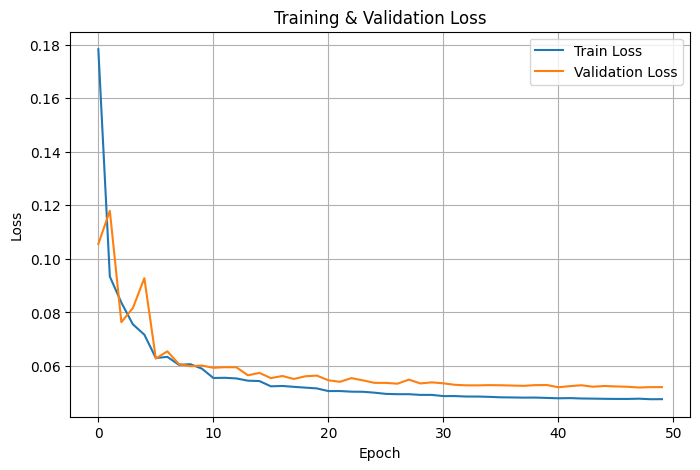

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(metrics_history['train_loss'], label='Train Loss')
plt.plot(metrics_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Testing

In [32]:
models.test(model=model, test_iter=test_iter, n_pred=n_pred, n_his=n_his , scaler=scaler)

testing model started! 🔥🔥🔥


100%|██████████| 51/51 [00:04<00:00, 11.81it/s]


, prediction time step: 3 or next 15 minutes , MAPE 0.056626271456480026, RMSE 4.321357250213623, MAE 2.3627066612243652
, prediction time step: 6 or next 30 minutes , MAPE 0.07992714643478394, RMSE 6.112496376037598, MAE 3.238548994064331
, prediction time step: 9 or next 45 minutes , MAPE 0.09764806926250458, RMSE 7.3287458419799805, MAE 3.9110567569732666
Testing model finished! 🌊🌊🌊


### Visualize predictions

In [94]:
model.eval()
h_step_idx = np.arange(3, n_pred+1, 3) -  1 # 3,6,9 time step for val & test if n_pred=9
test_pred_list = []
all_ys = []

with torch.no_grad():
    for x, y in tqdm.tqdm(test_iter):
        all_ys.append(y)
        step_list = models.multi_pred(model, n_pred, n_his, x) # [n_pred, bs, n_vertex]
        test_pred_list.append(step_list) # list of [n_pred, bs, n_vertex], dim = [total_batch, n_pred, bs, n_vertex]



100%|██████████| 51/51 [00:04<00:00, 11.65it/s]


In [95]:
all_ys = torch.cat(all_ys, dim=0)  # shape: [total_samples, n_pred, n_vertex]

In [96]:
all_ys.shape

torch.Size([2514, 9, 228])

In [97]:
all_ys_next_15_minutes = all_ys[:,2,:]

In [98]:
all_ys_next_5_minutes = all_ys[:,0,:]

In [99]:
all_ys_next_15_minutes.shape

torch.Size([2514, 228])

In [100]:
test_pred_array = np.concatenate(test_pred_list, axis=1)  # [n_pred, total_samples, n_vertex]
test_pred_H = test_pred_array[h_step_idx] # [len(h_step_idx), total_samples, n_vertex]

In [101]:
test_pred_H_next_15_minutes = test_pred_H[0,:,:]

In [86]:
test_pred_H_next_15_minutes.shape

(2514, 228)

In [102]:
all_ys_next_5_minutes = all_ys_next_5_minutes.cpu().numpy()
all_ys_next_15_minutes = all_ys_next_15_minutes.cpu().numpy()


In [103]:
def inverse_transform(x, std, mean):
    return x * std + mean

### Plot prediction vs ground truth speed of 15 sensor
(all sequence test data) t+3 time step (next 15 minute/current time +  interval 10-15 minutes )

In [106]:
test_pred_H_sensor_one_next_15_minutes = inverse_transform(test_pred_H_next_15_minutes[:,0], scaler.scale_[0], scaler.mean_[0])
all_ys_sensor_one_next_15_minutes = inverse_transform(all_ys_next_15_minutes[:,0], scaler.scale_[0], scaler.mean_[0])

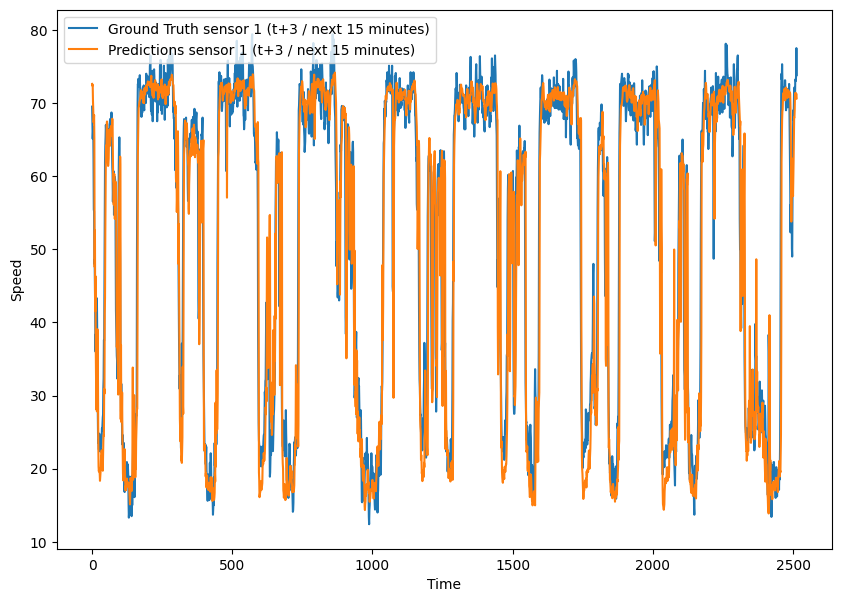

In [107]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,7))
plt.plot(range(len(all_ys_sensor_one_next_15_minutes)), all_ys_sensor_one_next_15_minutes, label='Ground Truth sensor 1 (t+3 / next 15 minutes)')
plt.plot(range(len(test_pred_H_sensor_one_next_15_minutes)), test_pred_H_sensor_one_next_15_minutes, label='Predictions sensor 1 (t+3 / next 15 minutes)')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend(loc="upper left")
plt.show()

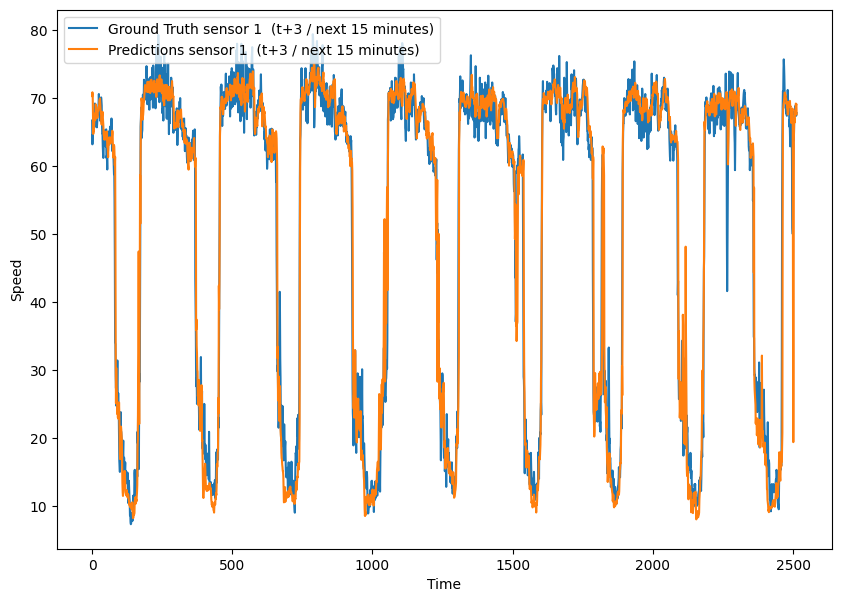

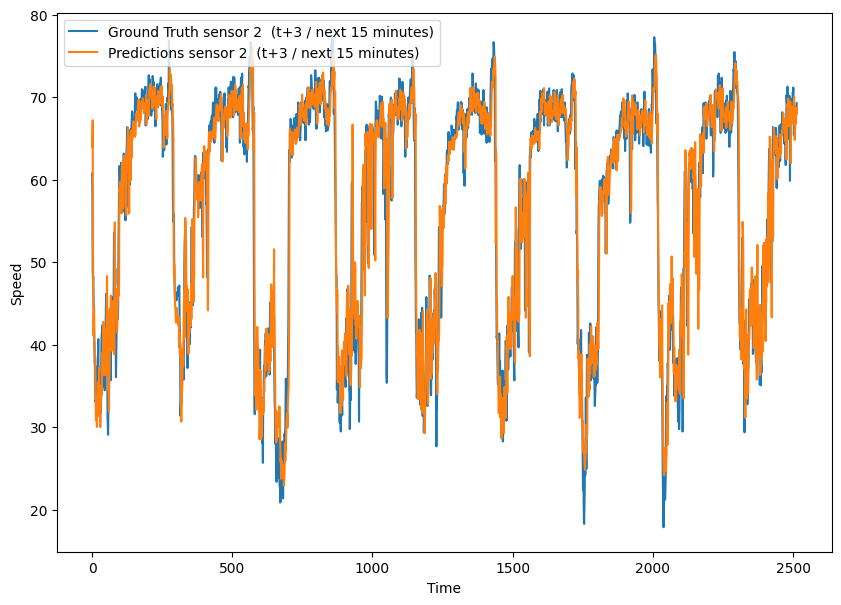

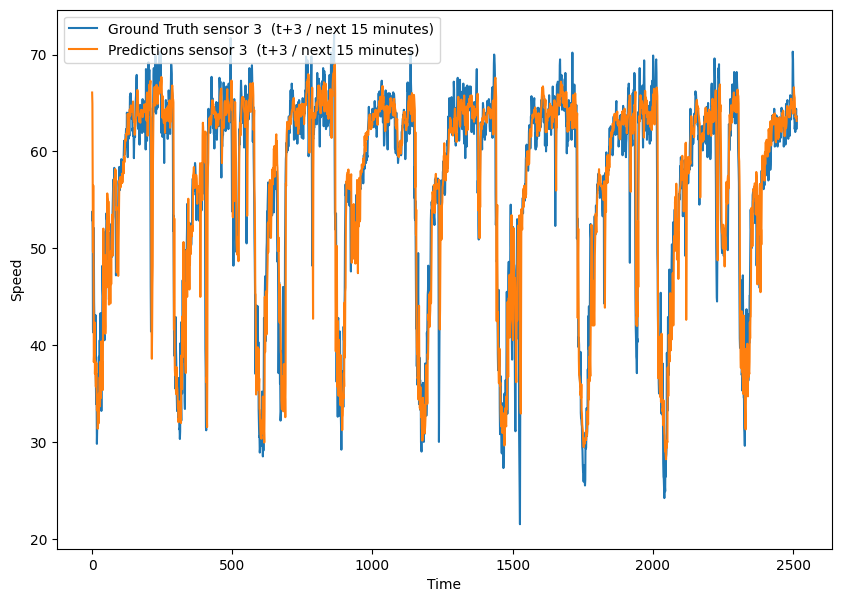

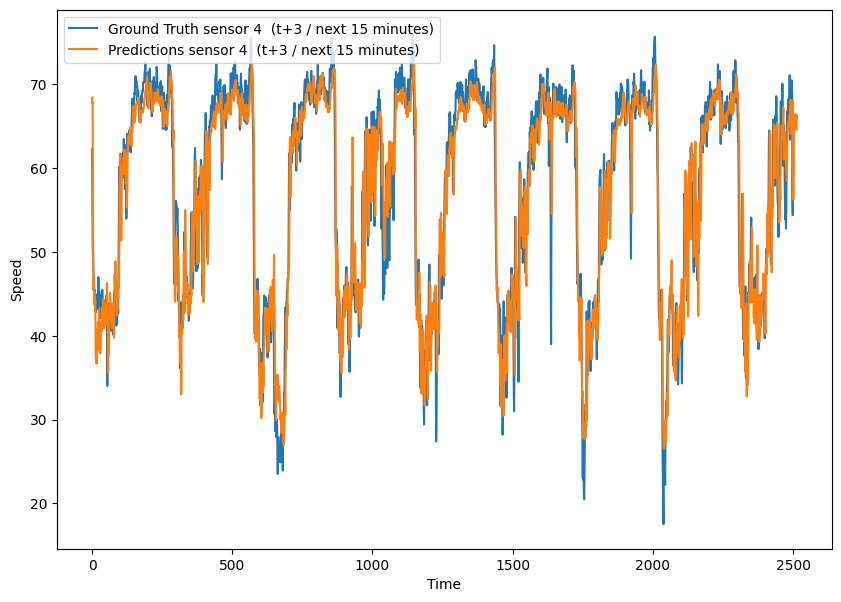

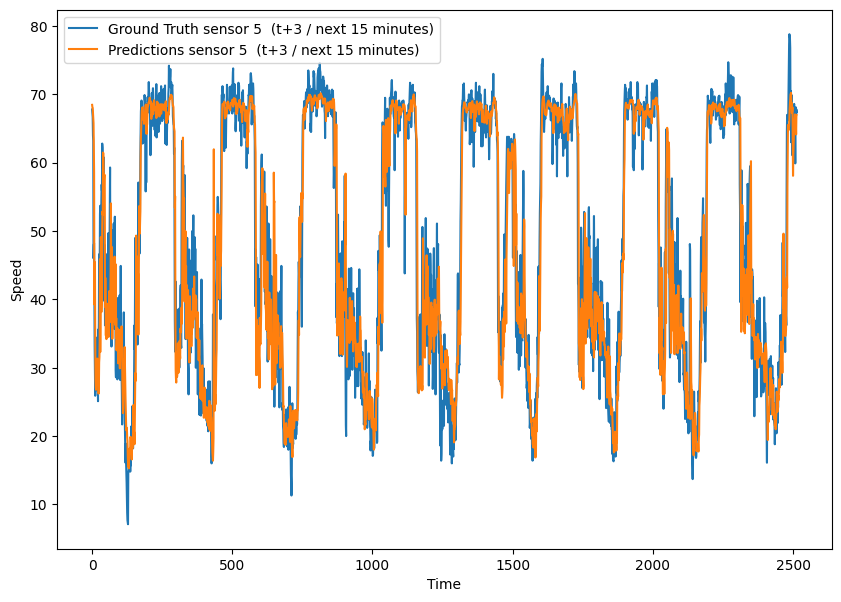

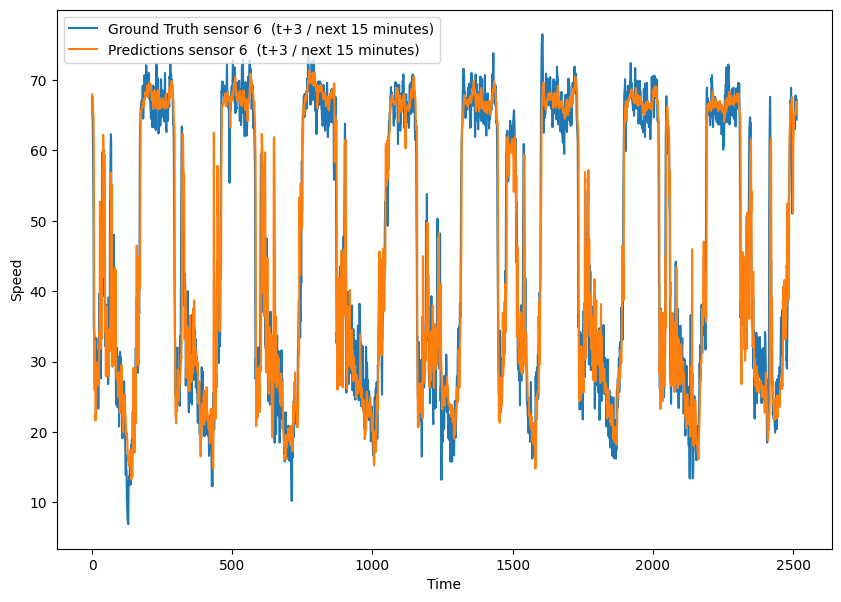

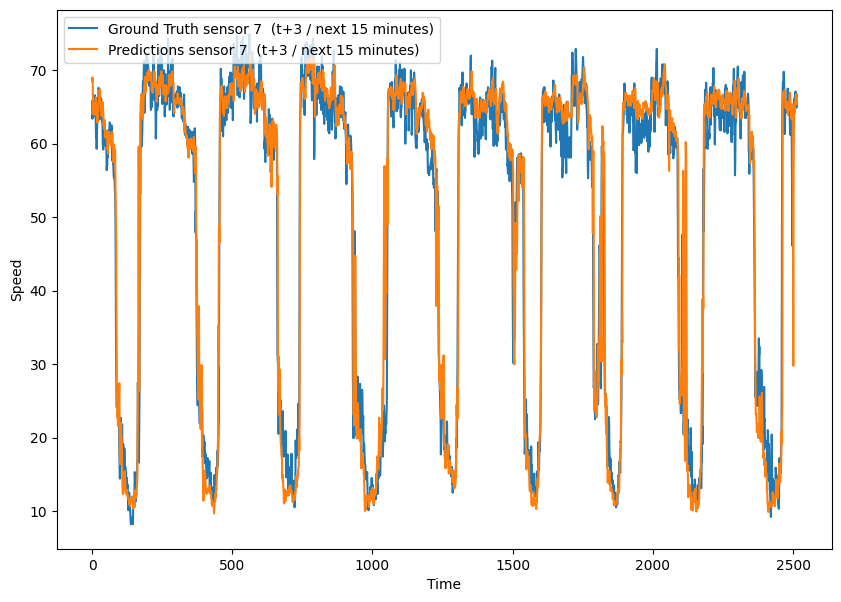

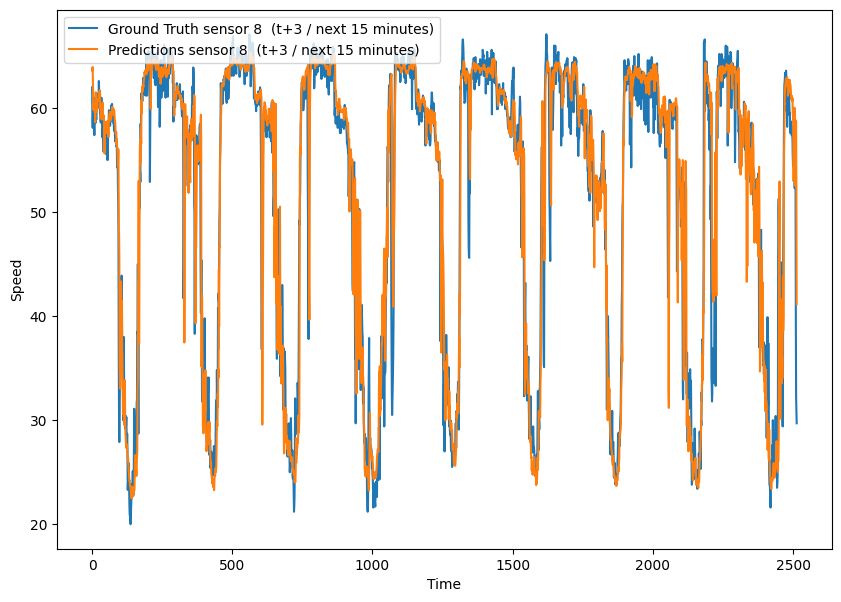

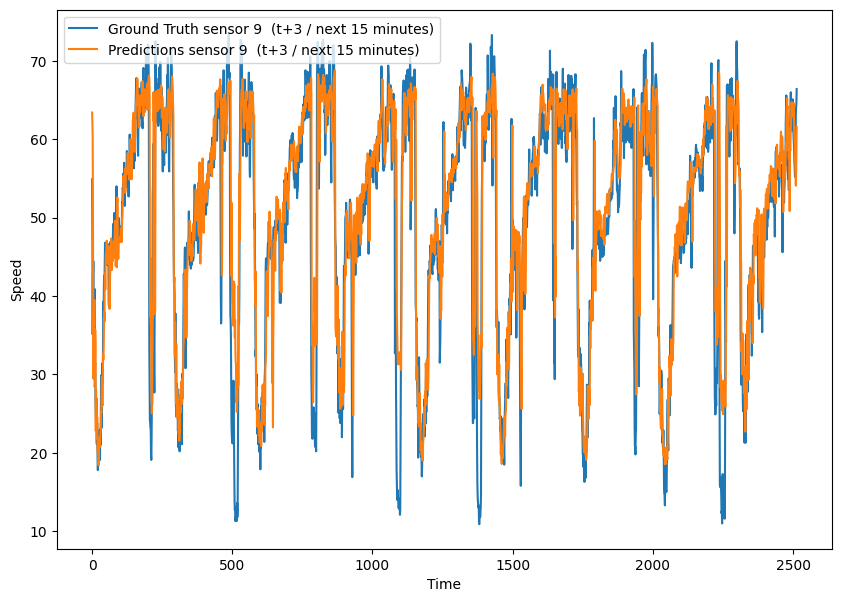

In [110]:
for sensor_idx in range(1,10):

    test_pred_H_sensor_idx = inverse_transform(test_pred_H_next_15_minutes[:,sensor_idx], scaler.scale_[sensor_idx], scaler.mean_[sensor_idx])
    all_ys_sensor_idx = inverse_transform(all_ys_next_15_minutes[:,sensor_idx], scaler.scale_[sensor_idx], scaler.mean_[sensor_idx])

    plt.figure(figsize=(10,7))
    plt.plot(range(len(all_ys_sensor_idx)), all_ys_sensor_idx, label=f'Ground Truth sensor {sensor_idx}  (t+3 / next 15 minutes)')
    plt.plot(range(len(test_pred_H_sensor_idx)), test_pred_H_sensor_idx, label=f'Predictions sensor {sensor_idx}  (t+3 / next 15 minutes)')
    plt.xlabel('Time')
    plt.ylabel('Speed')
    plt.legend(loc="upper left")
    plt.show()

### Plot prediction vs ground truth speed of 10 sensor
(only first 288 time slot) t+3 time step (next 15 minute/current time +  interval 10-15 minutes )

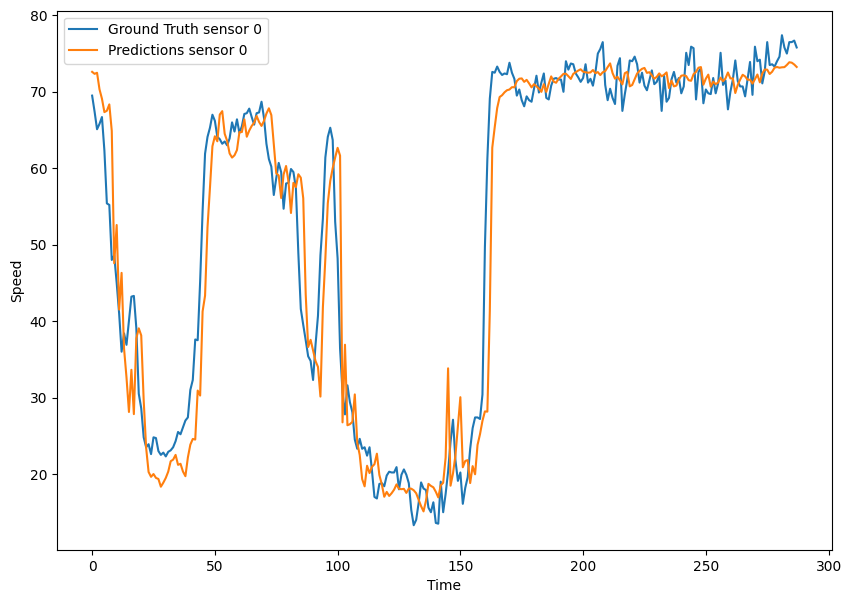

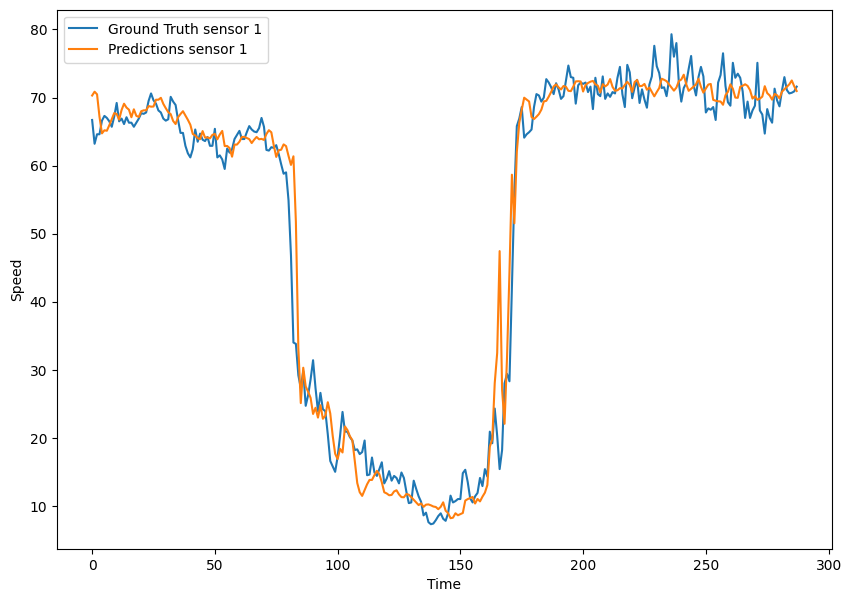

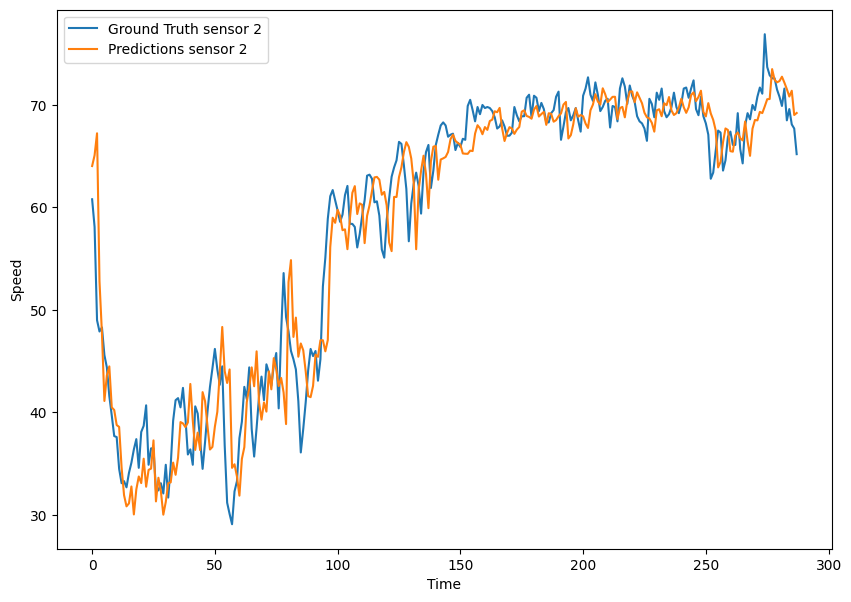

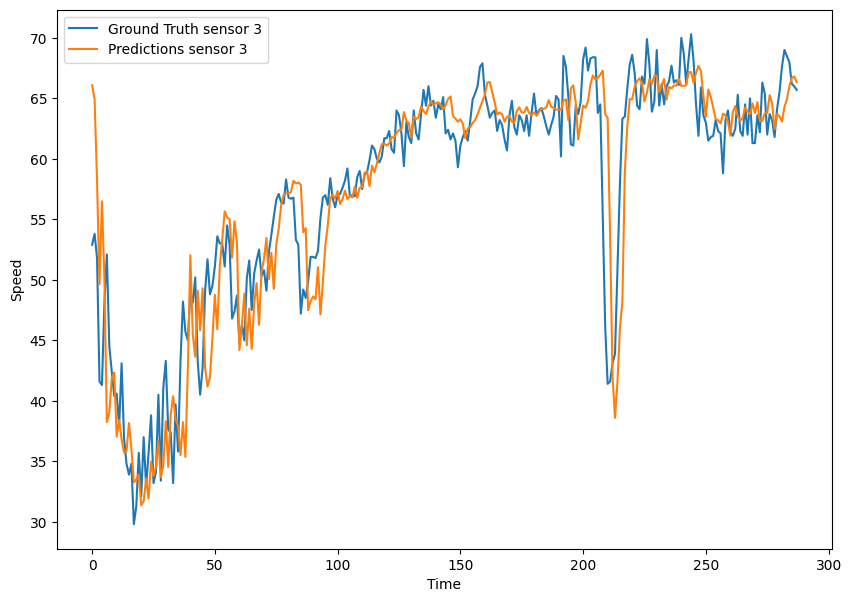

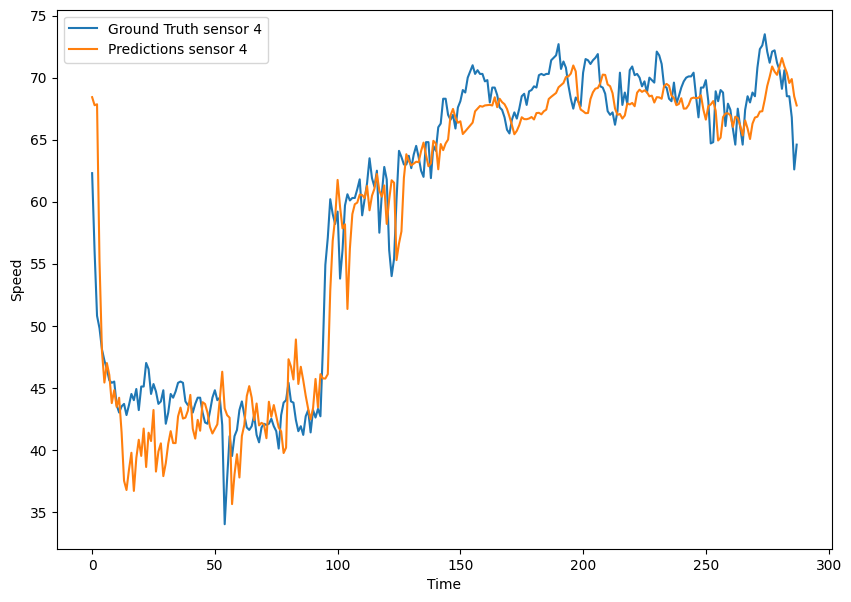

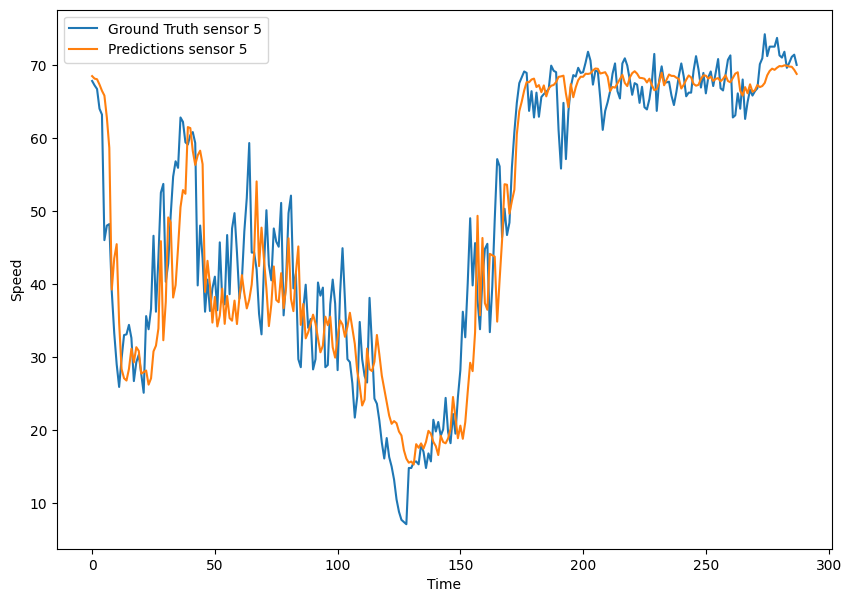

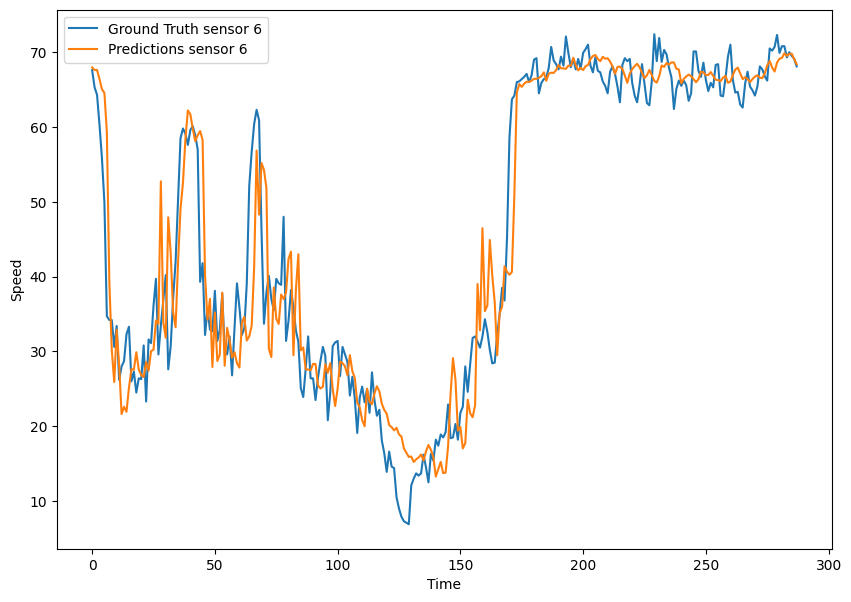

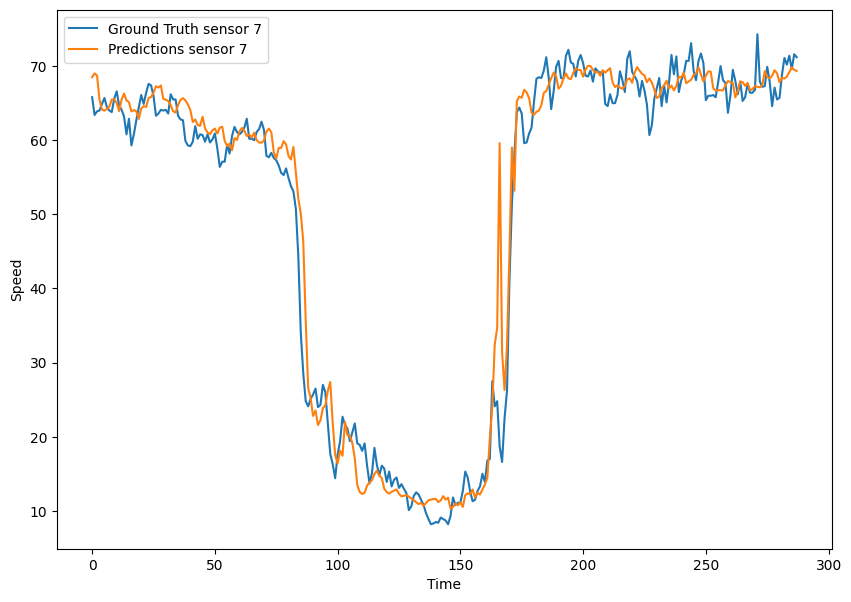

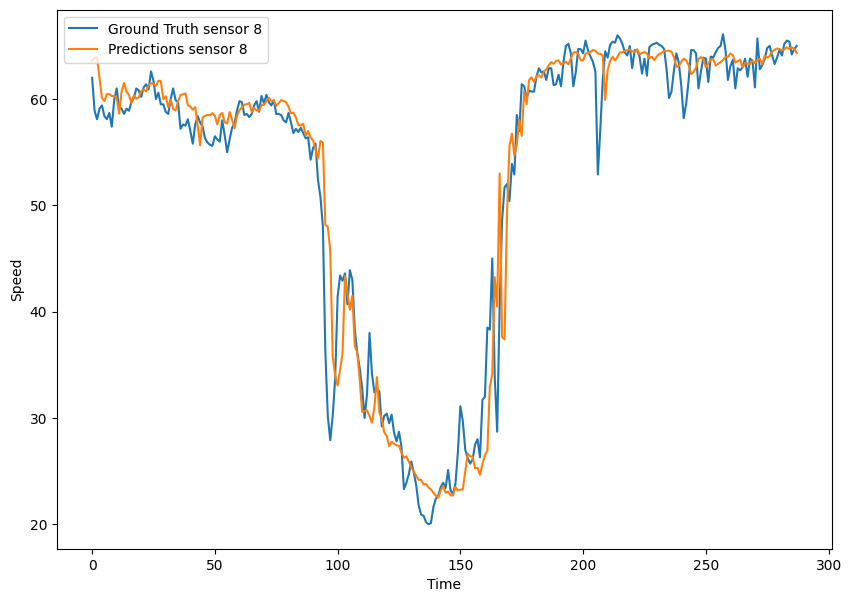

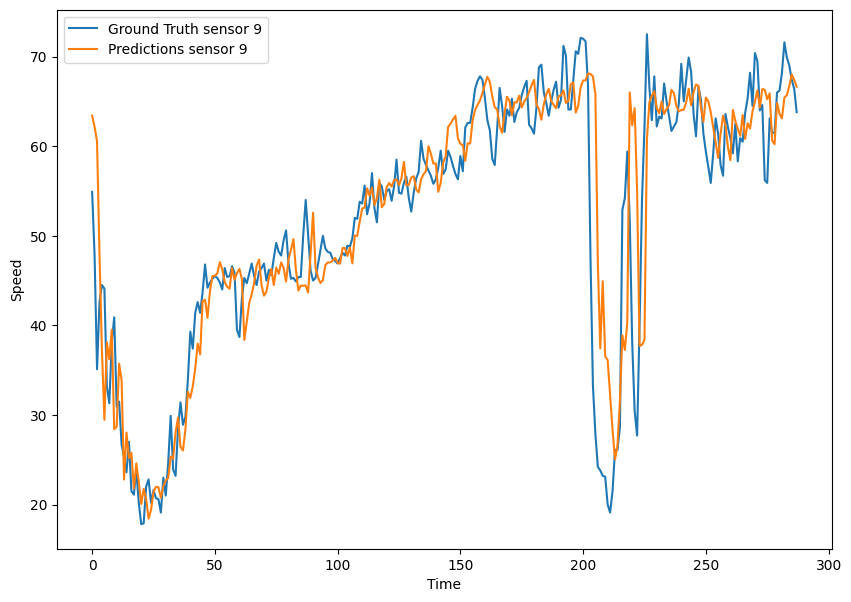

In [111]:
for sensor_idx in range(0,10):

    test_pred_H_sensor_idx = inverse_transform(test_pred_H_next_15_minutes[:288,sensor_idx], scaler.scale_[sensor_idx], scaler.mean_[sensor_idx])
    all_ys_sensor_idx = inverse_transform(all_ys_next_15_minutes[:288,sensor_idx], scaler.scale_[sensor_idx], scaler.mean_[sensor_idx])

    plt.figure(figsize=(10,7))
    plt.plot(range(len(all_ys_sensor_idx)), all_ys_sensor_idx, label=f'Ground Truth sensor {sensor_idx}')
    plt.plot(range(len(test_pred_H_sensor_idx)), test_pred_H_sensor_idx, label=f'Predictions sensor {sensor_idx}')
    plt.xlabel('Time')
    plt.ylabel('Speed')
    plt.legend(loc="upper left")
    plt.show()

### Plot prediction vs ground truth speed of 10 sensor
(only first 288 time slot) t+1 time step (next 5 minutes/current time +  interval 0-5 minutes )

In [115]:
test_pred_array_next_5_minutes = test_pred_array[0, :, :]

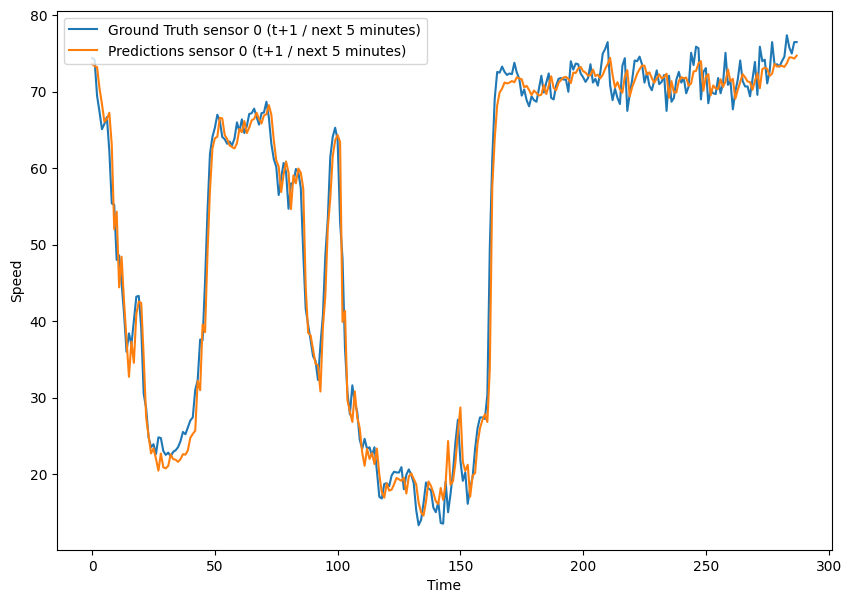

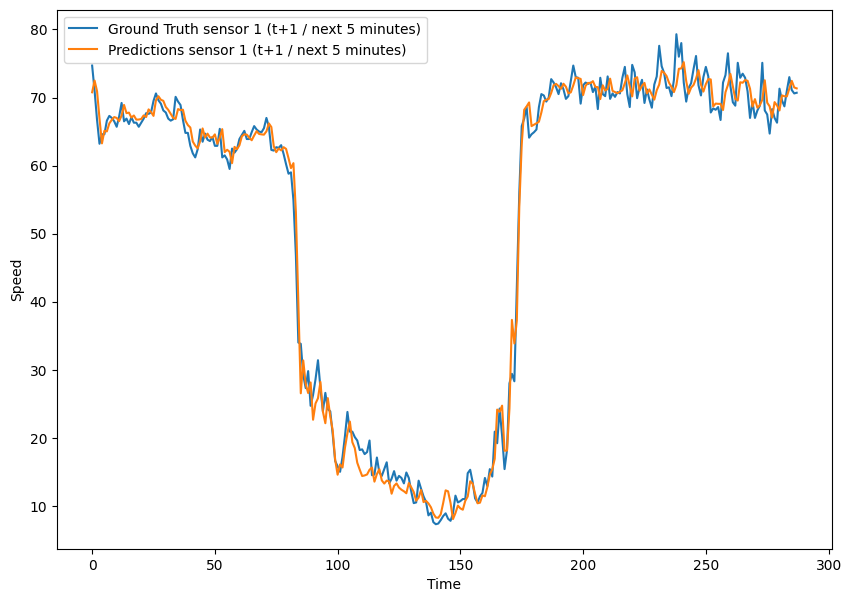

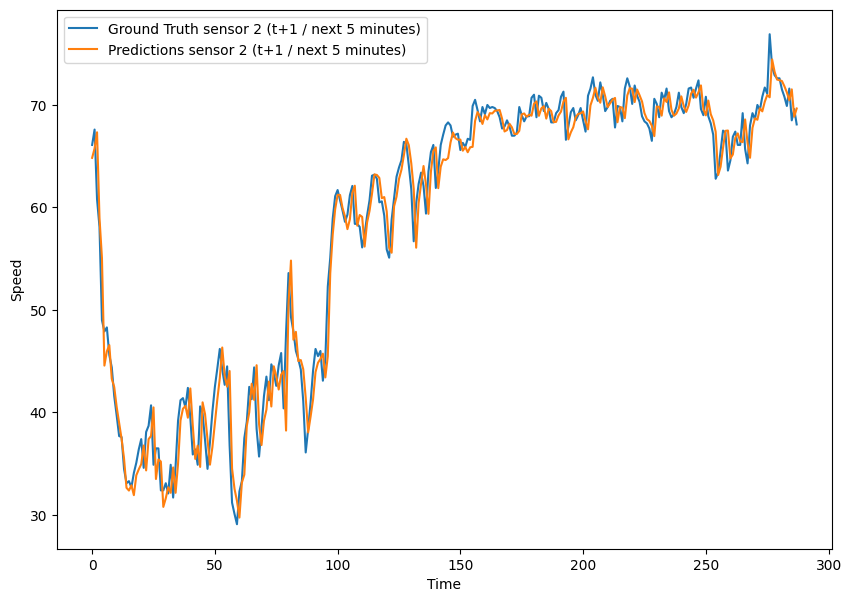

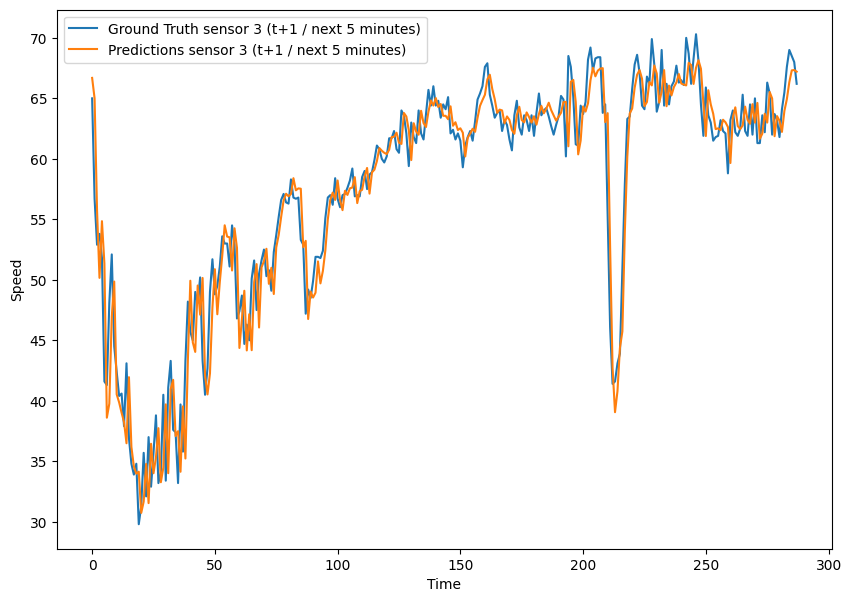

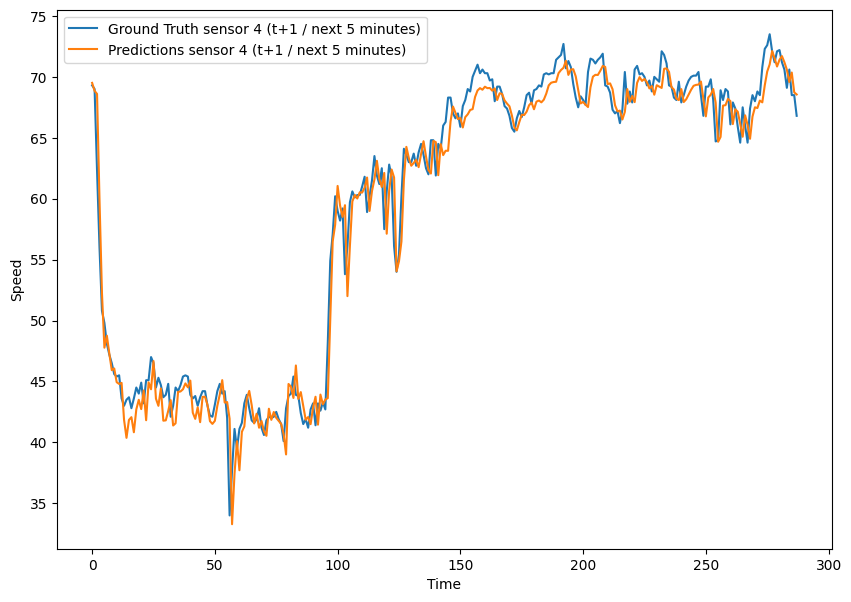

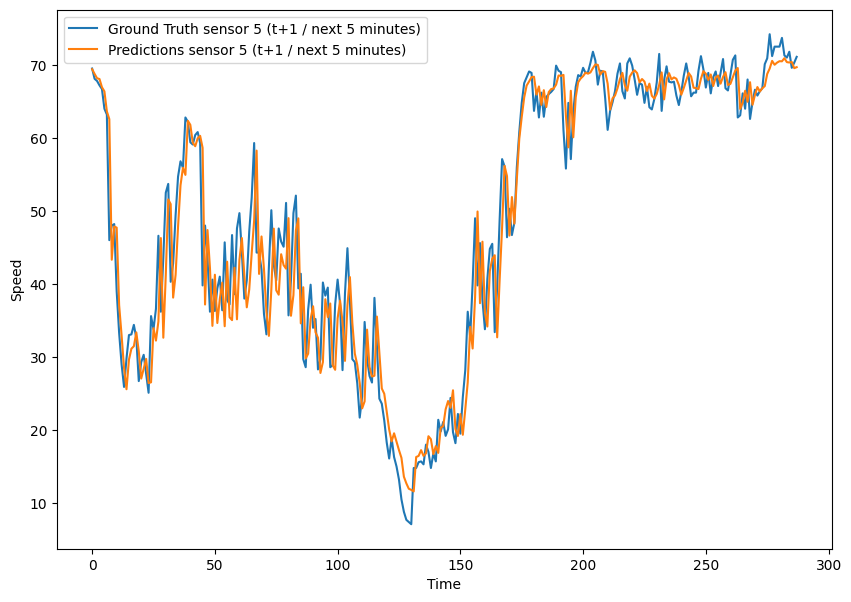

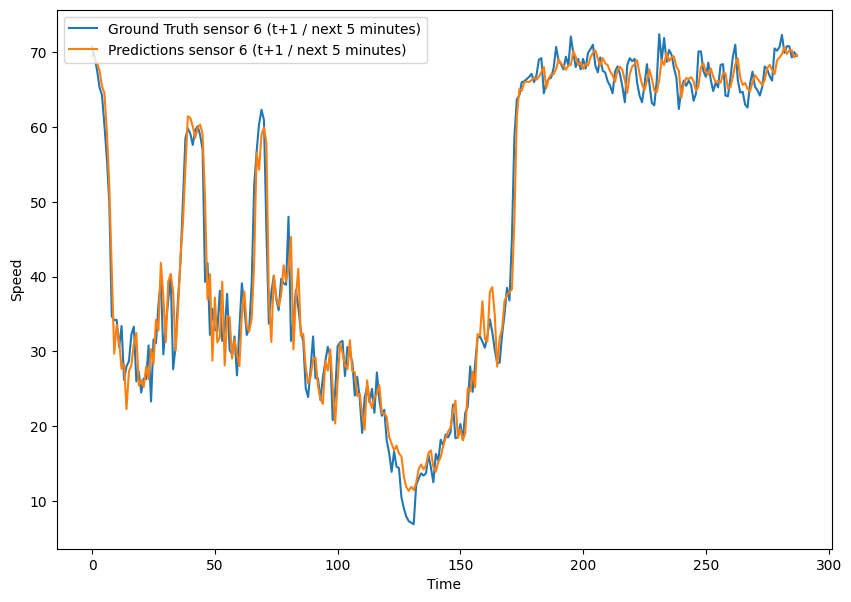

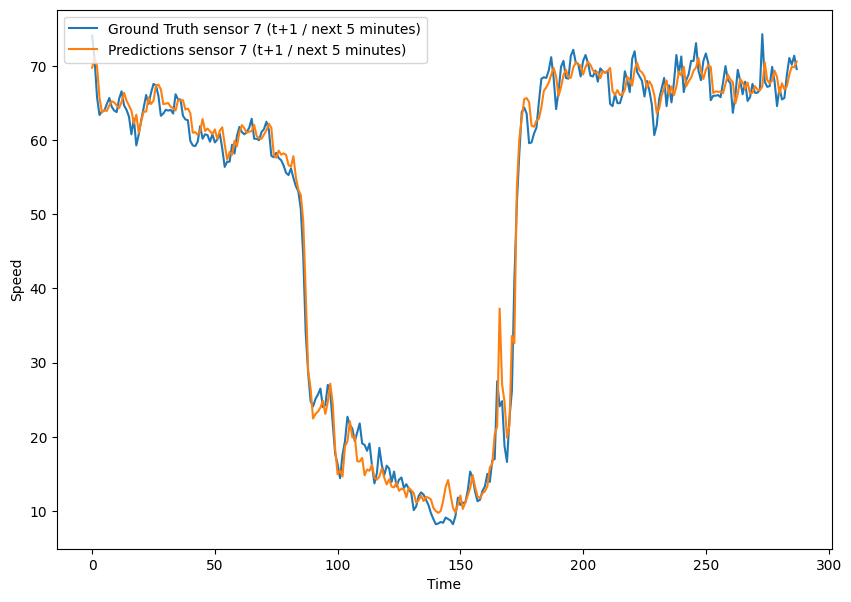

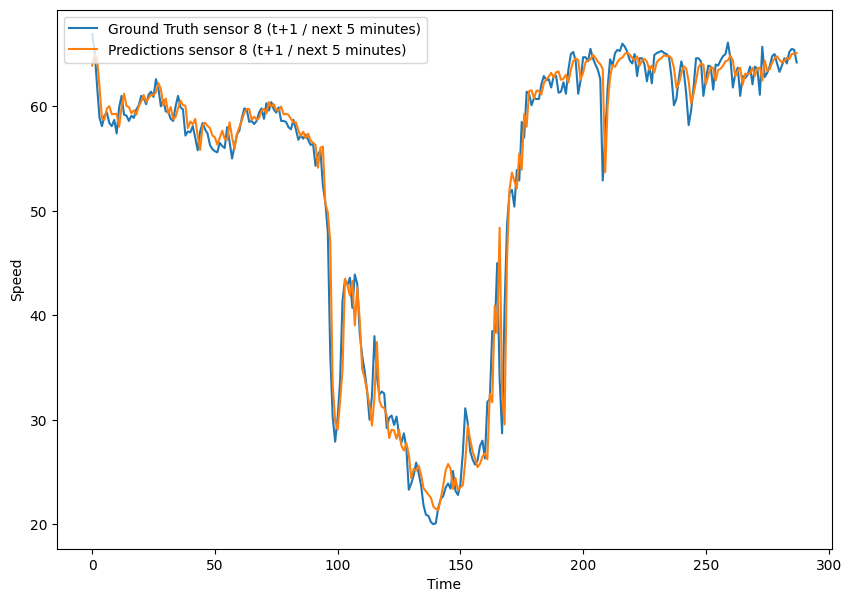

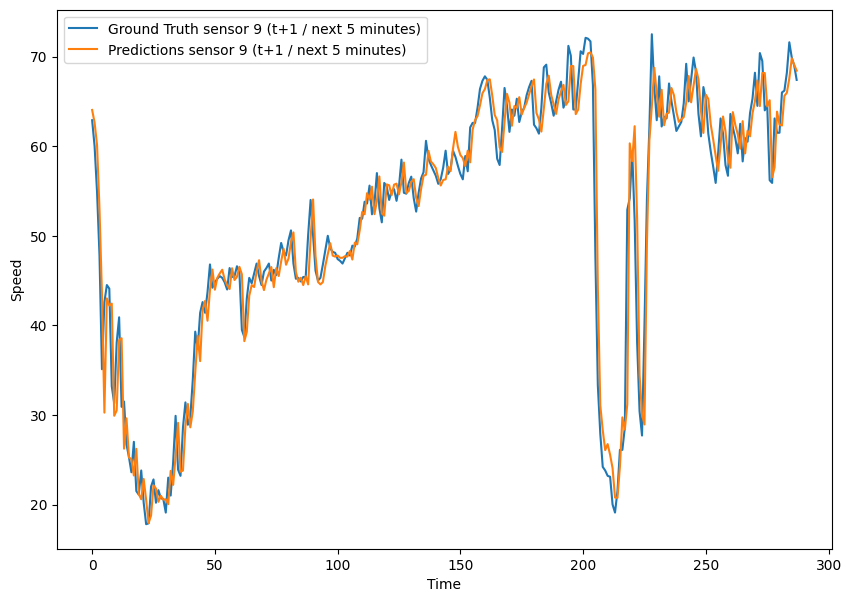

In [117]:
for sensor_idx in range(0,10):

    test_pred_H_sensor_idx = inverse_transform(test_pred_array_next_5_minutes[:288,sensor_idx], scaler.scale_[sensor_idx], scaler.mean_[sensor_idx])
    all_ys_sensor_idx = inverse_transform(all_ys_next_5_minutes[:288,sensor_idx], scaler.scale_[sensor_idx], scaler.mean_[sensor_idx])

    plt.figure(figsize=(10,7))
    plt.plot(range(len(all_ys_sensor_idx)), all_ys_sensor_idx, label=f'Ground Truth sensor {sensor_idx} (t+1 / next 5 minutes)')
    plt.plot(range(len(test_pred_H_sensor_idx)), test_pred_H_sensor_idx, label=f'Predictions sensor {sensor_idx} (t+1 / next 5 minutes)')
    plt.xlabel('Time')
    plt.ylabel('Speed')
    plt.legend(loc="upper left")
    plt.show()